In [1]:
# file kfkd.py
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
FTRAIN = '~/data/kaggle-facial-keypoint-detection/training.csv'
FTEST = '~/data/kaggle-facial-keypoint-detection/test.csv'

In [3]:
# Write function to load the data
# Normalize the target -- coordinates : current grid 96by96
# Normalize the features -- pixels : current range 255

def load(test = False, cols = None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN. 
    Pass a list of *cols* if you're only interested in a subset of the target columns"""
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) #Load pandas dataframe
    
    # The Image column has pixel values separated by space
    # convert these values to numpy arraus:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    
    if cols: # get a subset of columns
        df = df[list(cols) + ['Image']]
        
    print(df.count()) # prints the number of values for each column
    df = df.dropna() 
    # drop all rows that have missing values in them. reduce from 7049 partial to 2140 full examples
    
    # make feature matrix X
    # first convert pixel values from pandas 1D series to numpy 2D array
    # normalize pixel valuaes
    X = np.vstack(df['Image'].values)/255. # scale pixel values to [0,1]
    X = X.astype(np.float32) # make sure numeric val are float32
    # X is numpy.ndarray, shape (2140, 9216) == 7049 examples, 96 grid * 96 grid
    
    
    if not test: # only train data has target columns
        
        y = df[df.columns[:-1]].values #last column is X, we want the y targets here
        # y is numpy.ndarray, shape(2140, 30) -- 7049 examples, 30 targets each
        
        y = (y - 48) / 48 # scale target coordinates to [-1.1] (currently 96 by 96)
        X, y = shuffle(X, y, random_state = 42) #shuffle train data
        y = y.astype(np.float32)
        
    else:
        y = None # test data has no targets available
        
    return X,y

In [4]:
# Loading the data
X, y = load()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [5]:
# add to kfkd.py
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
net1 = NeuralNet(
    
    layers=[ 
    #three layers: one hidden layer
    ('input', layers.InputLayer),
    ('hidden', layers.DenseLayer),
    ('output', layers.DenseLayer),
    ],
    
    #layer parameters:
    input_shape = (None, 9216), # 96by96 input pixels per batch # None -- variable batch size (?)
    hidden_num_units = 100, # number of units in hidden layer   
    output_nonlinearity = None, #output layer uses identity function
    # none means output has no special activation function, 
    # it simply gives the linear combination of the activations in the hidden layer
    output_num_units = 30, #30 target values
    # default
    # hidden_nonlinearity = rectifier max(0,x)
    
    #optimization method:
    # all parameters starting with prefix update_ parametrize the update function
    # or optimization method. The update function will update the weights of our
    # network after each batch
    update = nesterov_momentum, # this is a gradient descent optimization method, 
    # works well with many problems
    # other methods are adagrad and rmsprop
    update_learning_rate = 0.01, # how large do we want to steps to be?
    update_momentum = 0.9,
    
    #note that we didn't specify a cost function to minimize
    #so default mean squared error MSE is used
    
    regression = True, 
    #flag True to indicate we're dealing with regression problem
    # as opposed to classification
    max_epochs = 400, #we want to train this many epochs
    verbose = 1 # print out information during training
)

X,y = load()
net1.fit(X,y)     
# Running these two lines output a table that grows one row per training epoch
# Loss: MSE on training or validation set
# NeuralNet automatically split data provided in X into training and validation
# 20% for validation
# can adjust by overriding eval_size = 0.2
# generally validation error keeps improving until the end

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

    102     0.00464     0.00522    0.88823  0.09s
    103     0.00462     0.00520    0.88737  0.09s
    104     0.00460     0.00518    0.88643  0.09s
    105     0.00458     0.00517    0.88559  0.08s
    106     0.00455     0.00515    0.88484  0.08s
    107     0.00453     0.00513    0.88400  0.08s
    108     0.00451     0.00511    0.88310  0.08s
    109     0.00449     0.00509    0.88231  0.08s
    110     0.00447     0.00508    0.88149  0.09s
    111     0.00445     0.00506    0.88071  0.08s
    112     0.00444     0.00504    0.87990  0.09s
    113     0.00442     0.00502    0.87904  0.09s
    114     0.00440     0.00501    0.87836  0.08s
    115     0.00438     0.00499    0.87744  0.09s
    116     0.00436     0.00497    0.87677  0.09s
    117     0.00434     0.00496    0.87592  0.08s
    118     0.00432     0.00494    0.87509  0.09s
    119     0.00430     0.00492    0.87441  0.08s
    120     0.00429     0.00491    0.87355  0.09s
    121     0.00427     0.00489    0.87277  0.09s


    223     0.00303     0.00380    0.79830  0.09s
    224     0.00302     0.00379    0.79767  0.09s
    225     0.00302     0.00378    0.79701  0.09s
    226     0.00301     0.00378    0.79634  0.09s
    227     0.00300     0.00377    0.79563  0.08s
    228     0.00299     0.00376    0.79484  0.08s
    229     0.00298     0.00376    0.79422  0.08s
    230     0.00298     0.00375    0.79360  0.08s
    231     0.00297     0.00374    0.79280  0.09s
    232     0.00296     0.00374    0.79219  0.08s
    233     0.00295     0.00373    0.79150  0.09s
    234     0.00294     0.00372    0.79079  0.08s
    235     0.00294     0.00372    0.79008  0.08s
    236     0.00293     0.00371    0.78940  0.09s
    237     0.00292     0.00370    0.78872  0.09s
    238     0.00291     0.00370    0.78798  0.08s
    239     0.00291     0.00369    0.78736  0.08s
    240     0.00290     0.00369    0.78665  0.08s
    241     0.00289     0.00368    0.78609  0.08s
    242     0.00289     0.00367    0.78550  0.09s


    356     0.00234     0.00324    0.72156  0.09s
    357     0.00233     0.00322    0.72338  0.09s
    358     0.00233     0.00321    0.72491  0.08s
    359     0.00233     0.00321    0.72626  0.09s
    360     0.00233     0.00320    0.72606  0.08s
    361     0.00232     0.00320    0.72304  0.09s
    362     0.00231     0.00321    0.71906  0.09s
    363     0.00230     0.00322    0.71556  0.09s
    364     0.00230     0.00323    0.71397  0.09s
    365     0.00230     0.00322    0.71470  0.08s
    366     0.00230     0.00320    0.71680  0.08s
    367     0.00229     0.00319    0.71820  0.09s
    368     0.00229     0.00318    0.71974  0.09s
    369     0.00229     0.00318    0.72084  0.09s
    370     0.00229     0.00318    0.72087  0.09s
    371     0.00228     0.00318    0.71884  0.09s
    372     0.00228     0.00319    0.71430  0.09s
    373     0.00227     0.00320    0.70898  0.08s
    374     0.00228     0.00322    0.70613  0.08s
    375     0.00228     0.00322    0.70662  0.08s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fb412c98ef0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fb412c98eb8>,
     check_input=True, custom_scores=None, hidden_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x7fb4120c8d08>,
     objective_loss_function=<function squared_error at 0x7fb412cd50d0>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7fb4120d49e8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo object at 0x7fb4120d4a20>],
     output_nonlinearity=None, output_num_units=30, regression=True,
     scores_train=[], scores_valid=

In [7]:
y.shape
#2140 examples
#each row [left_eye x, left_eye y, right_eye x, right_eye y....etc]

(2140, 30)

In [8]:
y

array([[ 0.38161111, -0.21757638, -0.40208334, ...,  0.44038889,
         0.03376389,  0.8259514 ],
       [ 0.4330242 , -0.21624877, -0.34668279, ...,  0.52398473,
        -0.08612007,  0.59259433],
       [ 0.3582826 , -0.26738405, -0.38800001, ...,  0.41946375,
        -0.01155797,  0.67042756],
       ..., 
       [ 0.40102914, -0.25295144, -0.37998059, ...,  0.38052428,
        -0.01551456,  0.75366992],
       [ 0.45343795, -0.1929708 , -0.40183941, ...,  0.72154742,
        -0.00937226,  0.89186132],
       [ 0.45054716, -0.32877925, -0.40111321, ...,  0.40483019,
         0.06266037,  0.7168113 ]], dtype=float32)

In [9]:
# Our validation error is 0.003255 here
# we need to convert this back 

import numpy as np
np.sqrt(0.003255)*48
# now it returns a proxy value for the Kaggle board score

2.7385251505144153

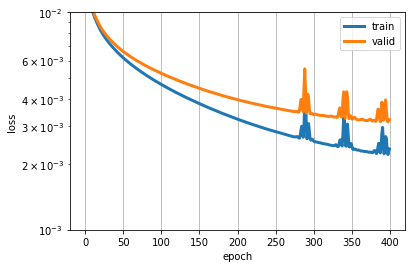

In [10]:
# object net1 keeps training history for each epoch
# we can access this record
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-3,1e-2)
plt.yscale("log")
plt.show()
# try epoch=1000 in net1 code to see same graph as tutorial

# we can see that our net overfits, but not too bad
# in particular, we dont see our validation error gets worse again
# so early stopping a technique commonly used to avoid over-fitting, won't be very useful
# we didnt use regularization, apart from choosing a small number of hidden neurons
# so overfitting is somewhat in control

In [11]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap = 'gray')
    axis.scatter(y[0::2]*48+48, y[1::2]*48+48, marker='x', s=10)

ImageId    1783
Image      1783
dtype: int64


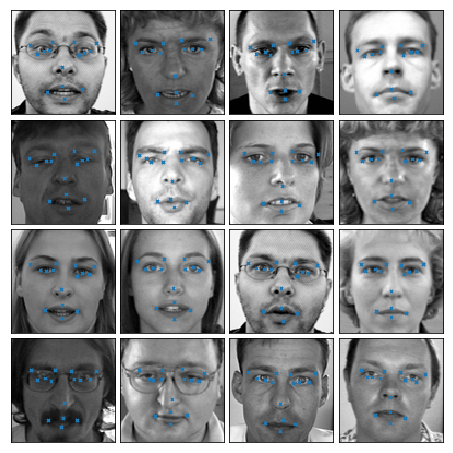

In [12]:
# load test set and predict
X, _ = load(test=True)
y_pred = net1.predict(X)

fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)
    
plt.show()

In [13]:
# When using convolutional layers in Lasagne, we have to prepare the input data such 
# that each sample is no longer a flat vector of 9,216 pixel intensities, 
# but a three-dimensional matrix with shape (c, 0, 1), where c is the number of channels (colors), 
# and 0 and 1 correspond to the x and y dimensions of the input image. In our case, 
# the concrete shape will be (1, 96, 96), because we're dealing with a single (gray) color 
# channel only.

def load2d(test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [14]:
# Each conv layer is followed by a 2x2 max-pooling layer. 
# Starting with 32 filters, we double the number of filters with every conv layer. 
# The densely connected hidden layers both have 500 units.

# no regularization or dropout
# using very small convolutional filtersm such as 3x3 or 2x2, is a pretty good regularizer by itself

net2 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,
    max_epochs=10,
    verbose=1,
    )

# Time Consuming -- test 10 epochs

In [15]:
X, y = load2d()  # load 2-d data
net2.fit(X, y)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fb412c98ef0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fb412c98eb8>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=10, more_params={},
     objective=<function objective at 0x7fb4120c8d0

In [16]:
import pickle

In [17]:
with open('net2.pickle', 'wb') as f:
    pickle.dump(net2, f, -1)

In [18]:
np.sqrt(0.001566) * 48

1.8994904579913006

ImageId    1783
Image      1783
dtype: int64
ImageId    1783
Image      1783
dtype: int64


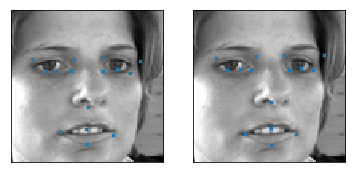

In [19]:
sample1 = load(test=True)[0][6:7]
sample2 = load2d(test=True)[0][6:7]
y_pred1 = net1.predict(sample1)[0]
y_pred2 = net2.predict(sample2)[0]

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred1, ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(sample1[0], y_pred2, ax)
plt.show()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

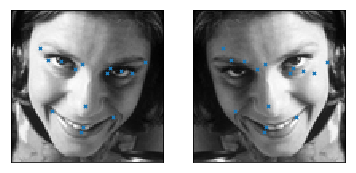

In [20]:
X, y = load2d()
X_flipped = X[:, :, :, ::-1]  # simple slice to flip all images

# plot two images:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_sample(X[1], y[1], ax)
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_sample(X_flipped[1], y[1], ax)
plt.show()

In [22]:
flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

# Let's see if we got it right:
df = read_csv(os.path.expanduser(FTRAIN))
for i, j in flip_indices:
    print("# {} -> {}".format(df.columns[i], df.columns[j]))

# left_eye_center_x -> right_eye_center_x
# left_eye_center_y -> right_eye_center_y
# left_eye_inner_corner_x -> right_eye_inner_corner_x
# left_eye_inner_corner_y -> right_eye_inner_corner_y
# left_eye_outer_corner_x -> right_eye_outer_corner_x
# left_eye_outer_corner_y -> right_eye_outer_corner_y
# left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
# left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
# left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
# left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
# mouth_left_corner_x -> mouth_right_corner_x
# mouth_left_corner_y -> mouth_right_corner_y


In [23]:
from nolearn.lasagne import BatchIterator

In [24]:
class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)
        print (Xb)
        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        print (bs)
        indices = np.random.choice(bs, int(bs/2), replace=False)
        print (indices)
        Xb[indices] = Xb[indices, :, :, ::-1]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

In [25]:
net3 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=0.01,
    update_momentum=0.9,
    
    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    max_epochs=10,
    verbose=1,
    )

In [26]:
import numpy as np
print( np.__version__)

1.13.1


In [27]:
net3.fit(X, y)

# Neural Network with 8051502 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x94x94
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

[[[[ 0.49019608  0.49019608  0.48235294 ...,  0.48235294  0.48235294
     0.60000002]
   [ 0.49019608  0.49019608  0.49019608 ...,  0.43921569  0.50980395
     0.58823532]
   [ 0.48627451  0.48627451  0.49411765 ...,  0.43921569  0.51764709
     0.56862748]
   ..., 
   [ 0.49019608  0.49411765  0.48627451 ...,  0.04705882  0.10588235
     0.16862746]
   [ 0.49803922  0.49019608  0.48627451 ...,  0.05490196  0.08235294
     0.1254902 ]
   [ 0.48627451  0.48627451  0.49019608 ...,  0.07450981  0.12941177
     0.20784314]]]


 [[[ 0.26274511  0.28627452  0.3137255  ...,  0.5411765   0.53725493
     0.53725493]
   [ 0.26666668  0.28627452  0.32156864 ...,  0.5333

[[[[ 0.94509804  0.9254902   0.86666667 ...,  0.68235296  0.71372551
     0.72156864]
   [ 0.92156863  0.88235295  0.86274511 ...,  0.6901961   0.70588237
     0.71372551]
   [ 0.92156863  0.90980393  0.92156863 ...,  0.7019608   0.66666669
     0.6901961 ]
   ..., 
   [ 0.7019608   0.71372551  0.7019608  ...,  0.67058825  0.66666669
     0.65882355]
   [ 0.70588237  0.69411767  0.70588237 ...,  0.66666669  0.67058825
     0.67058825]
   [ 0.70980394  0.69803923  0.69803923 ...,  0.67450982  0.67450982
     0.67450982]]]


 [[[ 0.50980395  0.50980395  0.5529412  ...,  0.70588237  0.7019608
     0.69803923]
   [ 0.50588238  0.49803922  0.5529412  ...,  0.7019608   0.7019608
     0.7019608 ]
   [ 0.50588238  0.50980395  0.5529412  ...,  0.71372551  0.70588237
     0.7019608 ]
   ..., 
   [ 0.08235294  0.07843138  0.07058824 ...,  0.15294118  0.17254902
     0.1882353 ]
   [ 0.09019608  0.08627451  0.07450981 ...,  0.16078432  0.17647059
     0.1882353 ]
   [ 0.10196079  0.08627451  0.070

[[[[ 0.87843138  0.88235295  0.88627452 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.89019608  0.88235295  0.89019608 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.88627452  0.89019608  0.88235295 ...,  0.99607843  0.99607843
     0.99607843]
   ..., 
   [ 0.83137256  0.8392157   0.8509804  ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.84705883  0.83529413  0.82745099 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.83137256  0.8392157   0.83529413 ...,  0.99215686  0.99607843
     0.99607843]]]


 [[[ 0.91764706  0.90980393  0.90588236 ...,  0.99607843  0.99607843
     0.99215686]
   [ 0.90980393  0.90196079  0.90980393 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.90196079  0.90196079  0.89411765 ...,  0.99607843  0.99607843
     0.99607843]
   ..., 
   [ 0.79215688  0.79607844  0.79607844 ...,  0.39607844  0.3019608
     0.25882354]
   [ 0.78823531  0.79215688  0.80000001 ...,  0.44313726  0.34117648
     0.25882354]
   [ 0.79607844  0.80000001  0.78

[[[[ 1.          1.          1.         ...,  0.64313728  0.67450982
     0.86274511]
   [ 1.          1.          1.         ...,  0.63529414  0.6901961
     0.7647059 ]
   [ 1.          1.          1.         ...,  0.64313728  0.69803923
     0.73725492]
   ..., 
   [ 0.11764706  0.1254902   0.15294118 ...,  0.52156866  0.59215689
     0.59607846]
   [ 0.11372549  0.11764706  0.15294118 ...,  0.5411765   0.5529412
     0.56470591]
   [ 0.11764706  0.11764706  0.14901961 ...,  0.58431375  0.56862748
     0.54509807]]]


 [[[ 0.76078433  0.75294119  0.77254903 ...,  0.52549022  0.53333336
     0.53333336]
   [ 0.7647059   0.78431374  0.76862746 ...,  0.50980395  0.47058824
     0.46666667]
   [ 0.7764706   0.78431374  0.76862746 ...,  0.46666667  0.43921569
     0.49411765]
   ..., 
   [ 0.38431373  0.36470589  0.33725491 ...,  0.5529412   0.50980395
     0.46666667]
   [ 0.40000001  0.38039216  0.34901962 ...,  0.53333336  0.49019608
     0.45882353]
   [ 0.41176471  0.38431373  0.360

[[[[ 0.4627451   0.49411765  0.43137255 ...,  0.1882353   0.24705882
     0.33725491]
   [ 0.52941179  0.49803922  0.40784314 ...,  0.17254902  0.21568628
     0.31764707]
   [ 0.5411765   0.47058824  0.39607844 ...,  0.17254902  0.21176471
     0.29803923]
   ..., 
   [ 0.18431373  0.43921569  0.79215688 ...,  0.46666667  0.44313726
     0.43921569]
   [ 0.59607846  0.80784315  0.68235296 ...,  0.47843137  0.44705883
     0.43921569]
   [ 0.74509805  0.54509807  0.40000001 ...,  0.49019608  0.44705883
     0.4509804 ]]]


 [[[ 1.          0.79607844  0.36862746 ...,  0.66274512  0.65882355
     0.66274512]
   [ 1.          0.78823531  0.38431373 ...,  0.66666669  0.66666669
     0.66274512]
   [ 1.          0.80000001  0.45490196 ...,  0.66666669  0.66274512
     0.66274512]
   ..., 
   [ 0.61176473  0.63137257  0.6156863  ...,  0.64705884  0.61176473
     0.58823532]
   [ 0.61960787  0.63137257  0.6156863  ...,  0.64313728  0.60000002
     0.58039218]
   [ 0.627451    0.64313728  0.6

[[[[ 0.69803923  0.82745099  0.78039217 ...,  0.45882353  0.5529412
     0.53725493]
   [ 0.73725492  0.83529413  0.68235296 ...,  0.58431375  0.55686277
     0.57647061]
   [ 0.78431374  0.74901962  0.68627453 ...,  0.65098041  0.57254905
     0.47450981]
   ..., 
   [ 0.23529412  0.21176471  0.25490198 ...,  0.57254905  0.55686277
     0.56862748]
   [ 0.19607843  0.32156864  0.23137255 ...,  0.60000002  0.627451
     0.61176473]
   [ 0.15294118  0.3137255   0.31764707 ...,  0.55686277  0.49019608
     0.41176471]]]


 [[[ 0.59607846  0.59607846  0.36470589 ...,  0.07843138  0.09019608
     0.10588235]
   [ 0.64705884  0.58039218  0.3137255  ...,  0.07843138  0.09019608
     0.09803922]
   [ 0.70588237  0.52941179  0.26274511 ...,  0.08235294  0.08235294
     0.09019608]
   ..., 
   [ 0.12156863  0.10196079  0.08235294 ...,  0.06666667  0.05882353
     0.0627451 ]
   [ 0.12941177  0.10196079  0.10588235 ...,  0.07450981  0.06666667
     0.0627451 ]
   [ 0.14117648  0.11372549  0.1137

[[[[ 1.          0.99607843  1.         ...,  0.47450981  0.94509804  1.        ]
   [ 0.99607843  1.          0.90588236 ...,  0.30980393  0.69411767  1.        ]
   [ 1.          0.99607843  0.65882355 ...,  0.23921569  0.41176471
     0.93333334]
   ..., 
   [ 1.          1.          1.         ...,  0.99607843  1.          1.        ]
   [ 1.          1.          1.         ...,  1.          1.          1.        ]
   [ 1.          1.          1.         ...,  1.          1.          1.        ]]]


 [[[ 0.59215689  0.6901961   0.72156864 ...,  0.21960784  0.41960785
     0.49019608]
   [ 0.61176473  0.66666669  0.71764708 ...,  0.1882353   0.35686275
     0.48627451]
   [ 0.60392159  0.65882355  0.75294119 ...,  0.18039216  0.28235295
     0.43921569]
   ..., 
   [ 0.47058824  0.47843137  0.49411765 ...,  0.3764706   0.34901962
     0.32156864]
   [ 0.46666667  0.47058824  0.48627451 ...,  0.40392157  0.38039216
     0.30980393]
   [ 0.47058824  0.47058824  0.51372552 ...,  0.3921

      2     0.02470     0.00751    3.28997  1.94s
[[[[ 0.60000002  0.48235294  0.48235294 ...,  0.48235294  0.49019608
     0.49019608]
   [ 0.58823532  0.50980395  0.43921569 ...,  0.49019608  0.49019608
     0.49019608]
   [ 0.56862748  0.51764709  0.43921569 ...,  0.49411765  0.48627451
     0.48627451]
   ..., 
   [ 0.16862746  0.10588235  0.04705882 ...,  0.48627451  0.49411765
     0.49019608]
   [ 0.1254902   0.08235294  0.05490196 ...,  0.48627451  0.49019608
     0.49803922]
   [ 0.20784314  0.12941177  0.07450981 ...,  0.49019608  0.48627451
     0.48627451]]]


 [[[ 0.26274511  0.28627452  0.3137255  ...,  0.5411765   0.53725493
     0.53725493]
   [ 0.26666668  0.28627452  0.32156864 ...,  0.53333336  0.5411765
     0.53725493]
   [ 0.27058825  0.28235295  0.30980393 ...,  0.5411765   0.5411765
     0.5411765 ]
   ..., 
   [ 0.52549022  0.52156866  0.50980395 ...,  0.50980395  0.50980395
     0.49803922]
   [ 0.53333336  0.53333336  0.51764709 ...,  0.5529412   0.55686277
 

[[[[ 0.72156864  0.71372551  0.68235296 ...,  0.86666667  0.9254902
     0.94509804]
   [ 0.71372551  0.70588237  0.6901961  ...,  0.86274511  0.88235295
     0.92156863]
   [ 0.6901961   0.66666669  0.7019608  ...,  0.92156863  0.90980393
     0.92156863]
   ..., 
   [ 0.65882355  0.66666669  0.67058825 ...,  0.7019608   0.71372551
     0.7019608 ]
   [ 0.67058825  0.67058825  0.66666669 ...,  0.70588237  0.69411767
     0.70588237]
   [ 0.67450982  0.67450982  0.67450982 ...,  0.69803923  0.69803923
     0.70980394]]]


 [[[ 0.50980395  0.50980395  0.5529412  ...,  0.70588237  0.7019608
     0.69803923]
   [ 0.50588238  0.49803922  0.5529412  ...,  0.7019608   0.7019608
     0.7019608 ]
   [ 0.50588238  0.50980395  0.5529412  ...,  0.71372551  0.70588237
     0.7019608 ]
   ..., 
   [ 0.08235294  0.07843138  0.07058824 ...,  0.15294118  0.17254902
     0.1882353 ]
   [ 0.09019608  0.08627451  0.07450981 ...,  0.16078432  0.17647059
     0.1882353 ]
   [ 0.10196079  0.08627451  0.0705

[[[[ 0.99607843  0.99607843  0.99607843 ...,  0.88627452  0.88235295
     0.87843138]
   [ 0.99607843  0.99607843  0.99607843 ...,  0.89019608  0.88235295
     0.89019608]
   [ 0.99607843  0.99607843  0.99607843 ...,  0.88235295  0.89019608
     0.88627452]
   ..., 
   [ 0.99607843  0.99607843  0.99607843 ...,  0.8509804   0.8392157
     0.83137256]
   [ 0.99607843  0.99607843  0.99607843 ...,  0.82745099  0.83529413
     0.84705883]
   [ 0.99607843  0.99607843  0.99215686 ...,  0.83529413  0.8392157
     0.83137256]]]


 [[[ 0.91764706  0.90980393  0.90588236 ...,  0.99607843  0.99607843
     0.99215686]
   [ 0.90980393  0.90196079  0.90980393 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.90196079  0.90196079  0.89411765 ...,  0.99607843  0.99607843
     0.99607843]
   ..., 
   [ 0.79215688  0.79607844  0.79607844 ...,  0.39607844  0.3019608
     0.25882354]
   [ 0.78823531  0.79215688  0.80000001 ...,  0.44313726  0.34117648
     0.25882354]
   [ 0.79607844  0.80000001  0.7882

[[[[ 1.          1.          1.         ...,  0.64313728  0.67450982
     0.86274511]
   [ 1.          1.          1.         ...,  0.63529414  0.6901961
     0.7647059 ]
   [ 1.          1.          1.         ...,  0.64313728  0.69803923
     0.73725492]
   ..., 
   [ 0.11764706  0.1254902   0.15294118 ...,  0.52156866  0.59215689
     0.59607846]
   [ 0.11372549  0.11764706  0.15294118 ...,  0.5411765   0.5529412
     0.56470591]
   [ 0.11764706  0.11764706  0.14901961 ...,  0.58431375  0.56862748
     0.54509807]]]


 [[[ 0.76078433  0.75294119  0.77254903 ...,  0.52549022  0.53333336
     0.53333336]
   [ 0.7647059   0.78431374  0.76862746 ...,  0.50980395  0.47058824
     0.46666667]
   [ 0.7764706   0.78431374  0.76862746 ...,  0.46666667  0.43921569
     0.49411765]
   ..., 
   [ 0.38431373  0.36470589  0.33725491 ...,  0.5529412   0.50980395
     0.46666667]
   [ 0.40000001  0.38039216  0.34901962 ...,  0.53333336  0.49019608
     0.45882353]
   [ 0.41176471  0.38431373  0.360

[[[[ 0.4627451   0.49411765  0.43137255 ...,  0.1882353   0.24705882
     0.33725491]
   [ 0.52941179  0.49803922  0.40784314 ...,  0.17254902  0.21568628
     0.31764707]
   [ 0.5411765   0.47058824  0.39607844 ...,  0.17254902  0.21176471
     0.29803923]
   ..., 
   [ 0.18431373  0.43921569  0.79215688 ...,  0.46666667  0.44313726
     0.43921569]
   [ 0.59607846  0.80784315  0.68235296 ...,  0.47843137  0.44705883
     0.43921569]
   [ 0.74509805  0.54509807  0.40000001 ...,  0.49019608  0.44705883
     0.4509804 ]]]


 [[[ 1.          0.79607844  0.36862746 ...,  0.66274512  0.65882355
     0.66274512]
   [ 1.          0.78823531  0.38431373 ...,  0.66666669  0.66666669
     0.66274512]
   [ 1.          0.80000001  0.45490196 ...,  0.66666669  0.66274512
     0.66274512]
   ..., 
   [ 0.61176473  0.63137257  0.6156863  ...,  0.64705884  0.61176473
     0.58823532]
   [ 0.61960787  0.63137257  0.6156863  ...,  0.64313728  0.60000002
     0.58039218]
   [ 0.627451    0.64313728  0.6

[[[[ 0.53725493  0.5529412   0.45882353 ...,  0.78039217  0.82745099
     0.69803923]
   [ 0.57647061  0.55686277  0.58431375 ...,  0.68235296  0.83529413
     0.73725492]
   [ 0.47450981  0.57254905  0.65098041 ...,  0.68627453  0.74901962
     0.78431374]
   ..., 
   [ 0.56862748  0.55686277  0.57254905 ...,  0.25490198  0.21176471
     0.23529412]
   [ 0.61176473  0.627451    0.60000002 ...,  0.23137255  0.32156864
     0.19607843]
   [ 0.41176471  0.49019608  0.55686277 ...,  0.31764707  0.3137255
     0.15294118]]]


 [[[ 0.59607846  0.59607846  0.36470589 ...,  0.07843138  0.09019608
     0.10588235]
   [ 0.64705884  0.58039218  0.3137255  ...,  0.07843138  0.09019608
     0.09803922]
   [ 0.70588237  0.52941179  0.26274511 ...,  0.08235294  0.08235294
     0.09019608]
   ..., 
   [ 0.12156863  0.10196079  0.08235294 ...,  0.06666667  0.05882353
     0.0627451 ]
   [ 0.12941177  0.10196079  0.10588235 ...,  0.07450981  0.06666667
     0.0627451 ]
   [ 0.14117648  0.11372549  0.11

[[[[ 1.          0.99607843  1.         ...,  0.47450981  0.94509804  1.        ]
   [ 0.99607843  1.          0.90588236 ...,  0.30980393  0.69411767  1.        ]
   [ 1.          0.99607843  0.65882355 ...,  0.23921569  0.41176471
     0.93333334]
   ..., 
   [ 1.          1.          1.         ...,  0.99607843  1.          1.        ]
   [ 1.          1.          1.         ...,  1.          1.          1.        ]
   [ 1.          1.          1.         ...,  1.          1.          1.        ]]]


 [[[ 0.49019608  0.41960785  0.21960784 ...,  0.72156864  0.6901961
     0.59215689]
   [ 0.48627451  0.35686275  0.1882353  ...,  0.71764708  0.66666669
     0.61176473]
   [ 0.43921569  0.28235295  0.18039216 ...,  0.75294119  0.65882355
     0.60392159]
   ..., 
   [ 0.32156864  0.34901962  0.3764706  ...,  0.49411765  0.47843137
     0.47058824]
   [ 0.30980393  0.38039216  0.40392157 ...,  0.48627451  0.47058824
     0.46666667]
   [ 0.33333334  0.37254903  0.39215687 ...,  0.51372

      4     0.00675     0.00607    1.11177  1.94s
[[[[ 0.60000002  0.48235294  0.48235294 ...,  0.48235294  0.49019608
     0.49019608]
   [ 0.58823532  0.50980395  0.43921569 ...,  0.49019608  0.49019608
     0.49019608]
   [ 0.56862748  0.51764709  0.43921569 ...,  0.49411765  0.48627451
     0.48627451]
   ..., 
   [ 0.16862746  0.10588235  0.04705882 ...,  0.48627451  0.49411765
     0.49019608]
   [ 0.1254902   0.08235294  0.05490196 ...,  0.48627451  0.49019608
     0.49803922]
   [ 0.20784314  0.12941177  0.07450981 ...,  0.49019608  0.48627451
     0.48627451]]]


 [[[ 0.26274511  0.28627452  0.3137255  ...,  0.5411765   0.53725493
     0.53725493]
   [ 0.26666668  0.28627452  0.32156864 ...,  0.53333336  0.5411765
     0.53725493]
   [ 0.27058825  0.28235295  0.30980393 ...,  0.5411765   0.5411765
     0.5411765 ]
   ..., 
   [ 0.52549022  0.52156866  0.50980395 ...,  0.50980395  0.50980395
     0.49803922]
   [ 0.53333336  0.53333336  0.51764709 ...,  0.5529412   0.55686277
 

[[[[ 0.72156864  0.71372551  0.68235296 ...,  0.86666667  0.9254902
     0.94509804]
   [ 0.71372551  0.70588237  0.6901961  ...,  0.86274511  0.88235295
     0.92156863]
   [ 0.6901961   0.66666669  0.7019608  ...,  0.92156863  0.90980393
     0.92156863]
   ..., 
   [ 0.65882355  0.66666669  0.67058825 ...,  0.7019608   0.71372551
     0.7019608 ]
   [ 0.67058825  0.67058825  0.66666669 ...,  0.70588237  0.69411767
     0.70588237]
   [ 0.67450982  0.67450982  0.67450982 ...,  0.69803923  0.69803923
     0.70980394]]]


 [[[ 0.50980395  0.50980395  0.5529412  ...,  0.70588237  0.7019608
     0.69803923]
   [ 0.50588238  0.49803922  0.5529412  ...,  0.7019608   0.7019608
     0.7019608 ]
   [ 0.50588238  0.50980395  0.5529412  ...,  0.71372551  0.70588237
     0.7019608 ]
   ..., 
   [ 0.08235294  0.07843138  0.07058824 ...,  0.15294118  0.17254902
     0.1882353 ]
   [ 0.09019608  0.08627451  0.07450981 ...,  0.16078432  0.17647059
     0.1882353 ]
   [ 0.10196079  0.08627451  0.0705

[[[[ 0.99607843  0.99607843  0.99607843 ...,  0.88627452  0.88235295
     0.87843138]
   [ 0.99607843  0.99607843  0.99607843 ...,  0.89019608  0.88235295
     0.89019608]
   [ 0.99607843  0.99607843  0.99607843 ...,  0.88235295  0.89019608
     0.88627452]
   ..., 
   [ 0.99607843  0.99607843  0.99607843 ...,  0.8509804   0.8392157
     0.83137256]
   [ 0.99607843  0.99607843  0.99607843 ...,  0.82745099  0.83529413
     0.84705883]
   [ 0.99607843  0.99607843  0.99215686 ...,  0.83529413  0.8392157
     0.83137256]]]


 [[[ 0.99215686  0.99607843  0.99607843 ...,  0.90588236  0.90980393
     0.91764706]
   [ 0.99607843  0.99607843  0.99607843 ...,  0.90980393  0.90196079
     0.90980393]
   [ 0.99607843  0.99607843  0.99607843 ...,  0.89411765  0.90196079
     0.90196079]
   ..., 
   [ 0.25882354  0.3019608   0.39607844 ...,  0.79607844  0.79607844
     0.79215688]
   [ 0.25882354  0.34117648  0.44313726 ...,  0.80000001  0.79215688
     0.78823531]
   [ 0.3019608   0.28627452  0.380

[[[[ 0.86274511  0.67450982  0.64313728 ...,  1.          1.          1.        ]
   [ 0.7647059   0.6901961   0.63529414 ...,  1.          1.          1.        ]
   [ 0.73725492  0.69803923  0.64313728 ...,  1.          1.          1.        ]
   ..., 
   [ 0.59607846  0.59215689  0.52156866 ...,  0.15294118  0.1254902
     0.11764706]
   [ 0.56470591  0.5529412   0.5411765  ...,  0.15294118  0.11764706
     0.11372549]
   [ 0.54509807  0.56862748  0.58431375 ...,  0.14901961  0.11764706
     0.11764706]]]


 [[[ 0.53333336  0.53333336  0.52549022 ...,  0.77254903  0.75294119
     0.76078433]
   [ 0.46666667  0.47058824  0.50980395 ...,  0.76862746  0.78431374
     0.7647059 ]
   [ 0.49411765  0.43921569  0.46666667 ...,  0.76862746  0.78431374
     0.7764706 ]
   ..., 
   [ 0.46666667  0.50980395  0.5529412  ...,  0.33725491  0.36470589
     0.38431373]
   [ 0.45882353  0.49019608  0.53333336 ...,  0.34901962  0.38039216
     0.40000001]
   [ 0.47058824  0.47843137  0.51372552 ..., 

[[[[ 0.4627451   0.49411765  0.43137255 ...,  0.1882353   0.24705882
     0.33725491]
   [ 0.52941179  0.49803922  0.40784314 ...,  0.17254902  0.21568628
     0.31764707]
   [ 0.5411765   0.47058824  0.39607844 ...,  0.17254902  0.21176471
     0.29803923]
   ..., 
   [ 0.18431373  0.43921569  0.79215688 ...,  0.46666667  0.44313726
     0.43921569]
   [ 0.59607846  0.80784315  0.68235296 ...,  0.47843137  0.44705883
     0.43921569]
   [ 0.74509805  0.54509807  0.40000001 ...,  0.49019608  0.44705883
     0.4509804 ]]]


 [[[ 1.          0.79607844  0.36862746 ...,  0.66274512  0.65882355
     0.66274512]
   [ 1.          0.78823531  0.38431373 ...,  0.66666669  0.66666669
     0.66274512]
   [ 1.          0.80000001  0.45490196 ...,  0.66666669  0.66274512
     0.66274512]
   ..., 
   [ 0.61176473  0.63137257  0.6156863  ...,  0.64705884  0.61176473
     0.58823532]
   [ 0.61960787  0.63137257  0.6156863  ...,  0.64313728  0.60000002
     0.58039218]
   [ 0.627451    0.64313728  0.6

[[[[ 0.69803923  0.82745099  0.78039217 ...,  0.45882353  0.5529412
     0.53725493]
   [ 0.73725492  0.83529413  0.68235296 ...,  0.58431375  0.55686277
     0.57647061]
   [ 0.78431374  0.74901962  0.68627453 ...,  0.65098041  0.57254905
     0.47450981]
   ..., 
   [ 0.23529412  0.21176471  0.25490198 ...,  0.57254905  0.55686277
     0.56862748]
   [ 0.19607843  0.32156864  0.23137255 ...,  0.60000002  0.627451
     0.61176473]
   [ 0.15294118  0.3137255   0.31764707 ...,  0.55686277  0.49019608
     0.41176471]]]


 [[[ 0.10588235  0.09019608  0.07843138 ...,  0.36470589  0.59607846
     0.59607846]
   [ 0.09803922  0.09019608  0.07843138 ...,  0.3137255   0.58039218
     0.64705884]
   [ 0.09019608  0.08235294  0.08235294 ...,  0.26274511  0.52941179
     0.70588237]
   ..., 
   [ 0.0627451   0.05882353  0.06666667 ...,  0.08235294  0.10196079
     0.12156863]
   [ 0.0627451   0.06666667  0.07450981 ...,  0.10588235  0.10196079
     0.12941177]
   [ 0.06666667  0.07843138  0.0823

[[[[ 1.          0.99607843  1.         ...,  0.47450981  0.94509804  1.        ]
   [ 0.99607843  1.          0.90588236 ...,  0.30980393  0.69411767  1.        ]
   [ 1.          0.99607843  0.65882355 ...,  0.23921569  0.41176471
     0.93333334]
   ..., 
   [ 1.          1.          1.         ...,  0.99607843  1.          1.        ]
   [ 1.          1.          1.         ...,  1.          1.          1.        ]
   [ 1.          1.          1.         ...,  1.          1.          1.        ]]]


 [[[ 0.59215689  0.6901961   0.72156864 ...,  0.21960784  0.41960785
     0.49019608]
   [ 0.61176473  0.66666669  0.71764708 ...,  0.1882353   0.35686275
     0.48627451]
   [ 0.60392159  0.65882355  0.75294119 ...,  0.18039216  0.28235295
     0.43921569]
   ..., 
   [ 0.47058824  0.47843137  0.49411765 ...,  0.3764706   0.34901962
     0.32156864]
   [ 0.46666667  0.47058824  0.48627451 ...,  0.40392157  0.38039216
     0.30980393]
   [ 0.47058824  0.47058824  0.51372552 ...,  0.3921

      6     0.00602     0.00562    1.07123  1.94s
[[[[ 0.49019608  0.49019608  0.48235294 ...,  0.48235294  0.48235294
     0.60000002]
   [ 0.49019608  0.49019608  0.49019608 ...,  0.43921569  0.50980395
     0.58823532]
   [ 0.48627451  0.48627451  0.49411765 ...,  0.43921569  0.51764709
     0.56862748]
   ..., 
   [ 0.49019608  0.49411765  0.48627451 ...,  0.04705882  0.10588235
     0.16862746]
   [ 0.49803922  0.49019608  0.48627451 ...,  0.05490196  0.08235294
     0.1254902 ]
   [ 0.48627451  0.48627451  0.49019608 ...,  0.07450981  0.12941177
     0.20784314]]]


 [[[ 0.26274511  0.28627452  0.3137255  ...,  0.5411765   0.53725493
     0.53725493]
   [ 0.26666668  0.28627452  0.32156864 ...,  0.53333336  0.5411765
     0.53725493]
   [ 0.27058825  0.28235295  0.30980393 ...,  0.5411765   0.5411765
     0.5411765 ]
   ..., 
   [ 0.52549022  0.52156866  0.50980395 ...,  0.50980395  0.50980395
     0.49803922]
   [ 0.53333336  0.53333336  0.51764709 ...,  0.5529412   0.55686277
 

[[[[ 0.94509804  0.9254902   0.86666667 ...,  0.68235296  0.71372551
     0.72156864]
   [ 0.92156863  0.88235295  0.86274511 ...,  0.6901961   0.70588237
     0.71372551]
   [ 0.92156863  0.90980393  0.92156863 ...,  0.7019608   0.66666669
     0.6901961 ]
   ..., 
   [ 0.7019608   0.71372551  0.7019608  ...,  0.67058825  0.66666669
     0.65882355]
   [ 0.70588237  0.69411767  0.70588237 ...,  0.66666669  0.67058825
     0.67058825]
   [ 0.70980394  0.69803923  0.69803923 ...,  0.67450982  0.67450982
     0.67450982]]]


 [[[ 0.69803923  0.7019608   0.70588237 ...,  0.5529412   0.50980395
     0.50980395]
   [ 0.7019608   0.7019608   0.7019608  ...,  0.5529412   0.49803922
     0.50588238]
   [ 0.7019608   0.70588237  0.71372551 ...,  0.5529412   0.50980395
     0.50588238]
   ..., 
   [ 0.1882353   0.17254902  0.15294118 ...,  0.07058824  0.07843138
     0.08235294]
   [ 0.1882353   0.17647059  0.16078432 ...,  0.07450981  0.08627451
     0.09019608]
   [ 0.18431373  0.17254902  0.1

[[[[ 0.87843138  0.88235295  0.88627452 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.89019608  0.88235295  0.89019608 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.88627452  0.89019608  0.88235295 ...,  0.99607843  0.99607843
     0.99607843]
   ..., 
   [ 0.83137256  0.8392157   0.8509804  ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.84705883  0.83529413  0.82745099 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.83137256  0.8392157   0.83529413 ...,  0.99215686  0.99607843
     0.99607843]]]


 [[[ 0.91764706  0.90980393  0.90588236 ...,  0.99607843  0.99607843
     0.99215686]
   [ 0.90980393  0.90196079  0.90980393 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.90196079  0.90196079  0.89411765 ...,  0.99607843  0.99607843
     0.99607843]
   ..., 
   [ 0.79215688  0.79607844  0.79607844 ...,  0.39607844  0.3019608
     0.25882354]
   [ 0.78823531  0.79215688  0.80000001 ...,  0.44313726  0.34117648
     0.25882354]
   [ 0.79607844  0.80000001  0.78

[[[[ 0.86274511  0.67450982  0.64313728 ...,  1.          1.          1.        ]
   [ 0.7647059   0.6901961   0.63529414 ...,  1.          1.          1.        ]
   [ 0.73725492  0.69803923  0.64313728 ...,  1.          1.          1.        ]
   ..., 
   [ 0.59607846  0.59215689  0.52156866 ...,  0.15294118  0.1254902
     0.11764706]
   [ 0.56470591  0.5529412   0.5411765  ...,  0.15294118  0.11764706
     0.11372549]
   [ 0.54509807  0.56862748  0.58431375 ...,  0.14901961  0.11764706
     0.11764706]]]


 [[[ 0.53333336  0.53333336  0.52549022 ...,  0.77254903  0.75294119
     0.76078433]
   [ 0.46666667  0.47058824  0.50980395 ...,  0.76862746  0.78431374
     0.7647059 ]
   [ 0.49411765  0.43921569  0.46666667 ...,  0.76862746  0.78431374
     0.7764706 ]
   ..., 
   [ 0.46666667  0.50980395  0.5529412  ...,  0.33725491  0.36470589
     0.38431373]
   [ 0.45882353  0.49019608  0.53333336 ...,  0.34901962  0.38039216
     0.40000001]
   [ 0.47058824  0.47843137  0.51372552 ..., 

[[[[ 0.33725491  0.24705882  0.1882353  ...,  0.43137255  0.49411765
     0.4627451 ]
   [ 0.31764707  0.21568628  0.17254902 ...,  0.40784314  0.49803922
     0.52941179]
   [ 0.29803923  0.21176471  0.17254902 ...,  0.39607844  0.47058824
     0.5411765 ]
   ..., 
   [ 0.43921569  0.44313726  0.46666667 ...,  0.79215688  0.43921569
     0.18431373]
   [ 0.43921569  0.44705883  0.47843137 ...,  0.68235296  0.80784315
     0.59607846]
   [ 0.4509804   0.44705883  0.49019608 ...,  0.40000001  0.54509807
     0.74509805]]]


 [[[ 1.          0.79607844  0.36862746 ...,  0.66274512  0.65882355
     0.66274512]
   [ 1.          0.78823531  0.38431373 ...,  0.66666669  0.66666669
     0.66274512]
   [ 1.          0.80000001  0.45490196 ...,  0.66666669  0.66274512
     0.66274512]
   ..., 
   [ 0.61176473  0.63137257  0.6156863  ...,  0.64705884  0.61176473
     0.58823532]
   [ 0.61960787  0.63137257  0.6156863  ...,  0.64313728  0.60000002
     0.58039218]
   [ 0.627451    0.64313728  0.6

[[[[ 0.53725493  0.5529412   0.45882353 ...,  0.78039217  0.82745099
     0.69803923]
   [ 0.57647061  0.55686277  0.58431375 ...,  0.68235296  0.83529413
     0.73725492]
   [ 0.47450981  0.57254905  0.65098041 ...,  0.68627453  0.74901962
     0.78431374]
   ..., 
   [ 0.56862748  0.55686277  0.57254905 ...,  0.25490198  0.21176471
     0.23529412]
   [ 0.61176473  0.627451    0.60000002 ...,  0.23137255  0.32156864
     0.19607843]
   [ 0.41176471  0.49019608  0.55686277 ...,  0.31764707  0.3137255
     0.15294118]]]


 [[[ 0.10588235  0.09019608  0.07843138 ...,  0.36470589  0.59607846
     0.59607846]
   [ 0.09803922  0.09019608  0.07843138 ...,  0.3137255   0.58039218
     0.64705884]
   [ 0.09019608  0.08235294  0.08235294 ...,  0.26274511  0.52941179
     0.70588237]
   ..., 
   [ 0.0627451   0.05882353  0.06666667 ...,  0.08235294  0.10196079
     0.12156863]
   [ 0.0627451   0.06666667  0.07450981 ...,  0.10588235  0.10196079
     0.12941177]
   [ 0.06666667  0.07843138  0.08

[[[[ 1.          0.99607843  1.         ...,  0.47450981  0.94509804  1.        ]
   [ 0.99607843  1.          0.90588236 ...,  0.30980393  0.69411767  1.        ]
   [ 1.          0.99607843  0.65882355 ...,  0.23921569  0.41176471
     0.93333334]
   ..., 
   [ 1.          1.          1.         ...,  0.99607843  1.          1.        ]
   [ 1.          1.          1.         ...,  1.          1.          1.        ]
   [ 1.          1.          1.         ...,  1.          1.          1.        ]]]


 [[[ 0.59215689  0.6901961   0.72156864 ...,  0.21960784  0.41960785
     0.49019608]
   [ 0.61176473  0.66666669  0.71764708 ...,  0.1882353   0.35686275
     0.48627451]
   [ 0.60392159  0.65882355  0.75294119 ...,  0.18039216  0.28235295
     0.43921569]
   ..., 
   [ 0.47058824  0.47843137  0.49411765 ...,  0.3764706   0.34901962
     0.32156864]
   [ 0.46666667  0.47058824  0.48627451 ...,  0.40392157  0.38039216
     0.30980393]
   [ 0.47058824  0.47058824  0.51372552 ...,  0.3921

      8     0.00570     0.00534    1.06593  1.94s
[[[[ 0.60000002  0.48235294  0.48235294 ...,  0.48235294  0.49019608
     0.49019608]
   [ 0.58823532  0.50980395  0.43921569 ...,  0.49019608  0.49019608
     0.49019608]
   [ 0.56862748  0.51764709  0.43921569 ...,  0.49411765  0.48627451
     0.48627451]
   ..., 
   [ 0.16862746  0.10588235  0.04705882 ...,  0.48627451  0.49411765
     0.49019608]
   [ 0.1254902   0.08235294  0.05490196 ...,  0.48627451  0.49019608
     0.49803922]
   [ 0.20784314  0.12941177  0.07450981 ...,  0.49019608  0.48627451
     0.48627451]]]


 [[[ 0.53725493  0.53725493  0.5411765  ...,  0.3137255   0.28627452
     0.26274511]
   [ 0.53725493  0.5411765   0.53333336 ...,  0.32156864  0.28627452
     0.26666668]
   [ 0.5411765   0.5411765   0.5411765  ...,  0.30980393  0.28235295
     0.27058825]
   ..., 
   [ 0.49803922  0.50980395  0.50980395 ...,  0.50980395  0.52156866
     0.52549022]
   [ 0.5411765   0.55686277  0.5529412  ...,  0.51764709  0.53333336

[[[[ 0.94509804  0.9254902   0.86666667 ...,  0.68235296  0.71372551
     0.72156864]
   [ 0.92156863  0.88235295  0.86274511 ...,  0.6901961   0.70588237
     0.71372551]
   [ 0.92156863  0.90980393  0.92156863 ...,  0.7019608   0.66666669
     0.6901961 ]
   ..., 
   [ 0.7019608   0.71372551  0.7019608  ...,  0.67058825  0.66666669
     0.65882355]
   [ 0.70588237  0.69411767  0.70588237 ...,  0.66666669  0.67058825
     0.67058825]
   [ 0.70980394  0.69803923  0.69803923 ...,  0.67450982  0.67450982
     0.67450982]]]


 [[[ 0.50980395  0.50980395  0.5529412  ...,  0.70588237  0.7019608
     0.69803923]
   [ 0.50588238  0.49803922  0.5529412  ...,  0.7019608   0.7019608
     0.7019608 ]
   [ 0.50588238  0.50980395  0.5529412  ...,  0.71372551  0.70588237
     0.7019608 ]
   ..., 
   [ 0.08235294  0.07843138  0.07058824 ...,  0.15294118  0.17254902
     0.1882353 ]
   [ 0.09019608  0.08627451  0.07450981 ...,  0.16078432  0.17647059
     0.1882353 ]
   [ 0.10196079  0.08627451  0.070

[[[[ 0.87843138  0.88235295  0.88627452 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.89019608  0.88235295  0.89019608 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.88627452  0.89019608  0.88235295 ...,  0.99607843  0.99607843
     0.99607843]
   ..., 
   [ 0.83137256  0.8392157   0.8509804  ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.84705883  0.83529413  0.82745099 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.83137256  0.8392157   0.83529413 ...,  0.99215686  0.99607843
     0.99607843]]]


 [[[ 0.91764706  0.90980393  0.90588236 ...,  0.99607843  0.99607843
     0.99215686]
   [ 0.90980393  0.90196079  0.90980393 ...,  0.99607843  0.99607843
     0.99607843]
   [ 0.90196079  0.90196079  0.89411765 ...,  0.99607843  0.99607843
     0.99607843]
   ..., 
   [ 0.79215688  0.79607844  0.79607844 ...,  0.39607844  0.3019608
     0.25882354]
   [ 0.78823531  0.79215688  0.80000001 ...,  0.44313726  0.34117648
     0.25882354]
   [ 0.79607844  0.80000001  0.78

[[[[ 1.          1.          1.         ...,  0.64313728  0.67450982
     0.86274511]
   [ 1.          1.          1.         ...,  0.63529414  0.6901961
     0.7647059 ]
   [ 1.          1.          1.         ...,  0.64313728  0.69803923
     0.73725492]
   ..., 
   [ 0.11764706  0.1254902   0.15294118 ...,  0.52156866  0.59215689
     0.59607846]
   [ 0.11372549  0.11764706  0.15294118 ...,  0.5411765   0.5529412
     0.56470591]
   [ 0.11764706  0.11764706  0.14901961 ...,  0.58431375  0.56862748
     0.54509807]]]


 [[[ 0.53333336  0.53333336  0.52549022 ...,  0.77254903  0.75294119
     0.76078433]
   [ 0.46666667  0.47058824  0.50980395 ...,  0.76862746  0.78431374
     0.7647059 ]
   [ 0.49411765  0.43921569  0.46666667 ...,  0.76862746  0.78431374
     0.7764706 ]
   ..., 
   [ 0.46666667  0.50980395  0.5529412  ...,  0.33725491  0.36470589
     0.38431373]
   [ 0.45882353  0.49019608  0.53333336 ...,  0.34901962  0.38039216
     0.40000001]
   [ 0.47058824  0.47843137  0.513

[[[[ 0.4627451   0.49411765  0.43137255 ...,  0.1882353   0.24705882
     0.33725491]
   [ 0.52941179  0.49803922  0.40784314 ...,  0.17254902  0.21568628
     0.31764707]
   [ 0.5411765   0.47058824  0.39607844 ...,  0.17254902  0.21176471
     0.29803923]
   ..., 
   [ 0.18431373  0.43921569  0.79215688 ...,  0.46666667  0.44313726
     0.43921569]
   [ 0.59607846  0.80784315  0.68235296 ...,  0.47843137  0.44705883
     0.43921569]
   [ 0.74509805  0.54509807  0.40000001 ...,  0.49019608  0.44705883
     0.4509804 ]]]


 [[[ 1.          0.79607844  0.36862746 ...,  0.66274512  0.65882355
     0.66274512]
   [ 1.          0.78823531  0.38431373 ...,  0.66666669  0.66666669
     0.66274512]
   [ 1.          0.80000001  0.45490196 ...,  0.66666669  0.66274512
     0.66274512]
   ..., 
   [ 0.61176473  0.63137257  0.6156863  ...,  0.64705884  0.61176473
     0.58823532]
   [ 0.61960787  0.63137257  0.6156863  ...,  0.64313728  0.60000002
     0.58039218]
   [ 0.627451    0.64313728  0.6

[[[[ 0.69803923  0.82745099  0.78039217 ...,  0.45882353  0.5529412
     0.53725493]
   [ 0.73725492  0.83529413  0.68235296 ...,  0.58431375  0.55686277
     0.57647061]
   [ 0.78431374  0.74901962  0.68627453 ...,  0.65098041  0.57254905
     0.47450981]
   ..., 
   [ 0.23529412  0.21176471  0.25490198 ...,  0.57254905  0.55686277
     0.56862748]
   [ 0.19607843  0.32156864  0.23137255 ...,  0.60000002  0.627451
     0.61176473]
   [ 0.15294118  0.3137255   0.31764707 ...,  0.55686277  0.49019608
     0.41176471]]]


 [[[ 0.59607846  0.59607846  0.36470589 ...,  0.07843138  0.09019608
     0.10588235]
   [ 0.64705884  0.58039218  0.3137255  ...,  0.07843138  0.09019608
     0.09803922]
   [ 0.70588237  0.52941179  0.26274511 ...,  0.08235294  0.08235294
     0.09019608]
   ..., 
   [ 0.12156863  0.10196079  0.08235294 ...,  0.06666667  0.05882353
     0.0627451 ]
   [ 0.12941177  0.10196079  0.10588235 ...,  0.07450981  0.06666667
     0.0627451 ]
   [ 0.14117648  0.11372549  0.1137

[[[[ 1.          0.99607843  1.         ...,  0.47450981  0.94509804  1.        ]
   [ 0.99607843  1.          0.90588236 ...,  0.30980393  0.69411767  1.        ]
   [ 1.          0.99607843  0.65882355 ...,  0.23921569  0.41176471
     0.93333334]
   ..., 
   [ 1.          1.          1.         ...,  0.99607843  1.          1.        ]
   [ 1.          1.          1.         ...,  1.          1.          1.        ]
   [ 1.          1.          1.         ...,  1.          1.          1.        ]]]


 [[[ 0.59215689  0.6901961   0.72156864 ...,  0.21960784  0.41960785
     0.49019608]
   [ 0.61176473  0.66666669  0.71764708 ...,  0.1882353   0.35686275
     0.48627451]
   [ 0.60392159  0.65882355  0.75294119 ...,  0.18039216  0.28235295
     0.43921569]
   ..., 
   [ 0.47058824  0.47843137  0.49411765 ...,  0.3764706   0.34901962
     0.32156864]
   [ 0.46666667  0.47058824  0.48627451 ...,  0.40392157  0.38039216
     0.30980393]
   [ 0.47058824  0.47058824  0.51372552 ...,  0.3921

     10     0.00548     0.00513    1.06861  1.94s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fb412c98ef0>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x7fb3f501c438>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=10, more_params={},
     objective=<function objective at 0x7fb4120c8d08>,
    

In [30]:
def float32(k):
    return np.cast['float32'](k)

In [32]:
import theano

In [33]:
import theano

net3 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    
    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    max_epochs=10,
    verbose=1,
    )

In [34]:
class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [35]:
net4 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),
    
    regression=True,
    #batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        ],
    max_epochs=300,
    verbose=1,
    )

X, y = load2d()
net4.fit(X, y)

with open('net4.pickle', 'wb') as f:
    pickle.dump(net4, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

    100     0.00381     0.00363    1.04721  1.82s
    101     0.00379     0.00362    1.04687  1.81s
    102     0.00378     0.00361    1.04652  1.82s
    103     0.00376     0.00360    1.04615  1.81s
    104     0.00375     0.00358    1.04574  1.82s
    105     0.00373     0.00357    1.04548  1.82s
    106     0.00371     0.00355    1.04496  1.82s
    107     0.00370     0.00354    1.04459  1.81s
    108     0.00368     0.00353    1.04405  1.82s
    109     0.00366     0.00351    1.04344  1.82s
    110     0.00365     0.00350    1.04299  1.82s
    111     0.00363     0.00348    1.04253  1.82s
    112     0.00361     0.00346    1.04169  1.82s
    113     0.00359     0.00345    1.04105  1.82s
    114     0.00357     0.00343    1.04050  1.82s
    115     0.00356     0.00342    1.03992  1.82s
    116     0.00354     0.00340    1.03923  1.82s
    117     0.00352     0.00339    1.03854  1.81s
    118     0.00350     0.00337    1.03787  1.81s
    119     0.00348     0.00336    1.03710  1.82s


    221     0.00190     0.00206    0.92444  1.82s
    222     0.00189     0.00205    0.92343  1.82s
    223     0.00188     0.00204    0.92238  1.82s
    224     0.00188     0.00204    0.92134  1.82s
    225     0.00187     0.00203    0.92037  1.82s
    226     0.00186     0.00202    0.91933  1.82s
    227     0.00185     0.00202    0.91830  1.82s
    228     0.00185     0.00201    0.91729  1.82s
    229     0.00184     0.00201    0.91624  1.81s
    230     0.00183     0.00200    0.91518  1.82s
    231     0.00183     0.00200    0.91418  1.82s
    232     0.00182     0.00199    0.91313  1.82s
    233     0.00181     0.00199    0.91216  1.82s
    234     0.00180     0.00198    0.91118  1.83s
    235     0.00180     0.00198    0.91017  1.83s
    236     0.00179     0.00197    0.90918  1.82s
    237     0.00179     0.00197    0.90821  1.83s
    238     0.00178     0.00196    0.90717  1.82s
    239     0.00177     0.00196    0.90617  1.82s
    240     0.00177     0.00195    0.90522  1.82s


In [38]:
import sys
sys.setrecursionlimit(10000)

In [39]:
from sklearn.metrics import mean_squared_error

In [40]:
class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

In [41]:
from collections import OrderedDict
from sklearn.base import clone

In [42]:
def fit_specialists():
    specialists = OrderedDict()

    for setting in SPECIALIST_SETTINGS:
        cols = setting['columns']
        X, y = load2d(cols=cols)

        model = clone(net)
        model.output_num_units = y.shape[1]
        model.batch_iterator_train.flip_indices = setting['flip_indices']
        # set number of epochs relative to number of training examples:
        model.max_epochs = int(1e7 / y.shape[0])
        if 'kwargs' in setting:
            # an option 'kwargs' in the settings list may be used to
            # set any other parameter of the net:
            vars(model).update(setting['kwargs'])

        print("Training model for columns {} for {} epochs".format(
            cols, model.max_epochs))
        model.fit(X, y)
        specialists[cols] = model

    with open('net-specialists.pickle', 'wb') as f:
        # we persist a dictionary with all models:
        pickle.dump(specialists, f, -1)

In [43]:
def fit_specialists(fname_pretrain=None):
    if fname_pretrain:  # !
        with open(fname_pretrain, 'rb') as f:  # !
            net_pretrain = pickle.load(f)  # !
    else:  # !
        net_pretrain = None  # !

    specialists = OrderedDict()

    for setting in SPECIALIST_SETTINGS:
        cols = setting['columns']
        X, y = load2d(cols=cols)

        model = clone(net)
        model.output_num_units = y.shape[1]
        model.batch_iterator_train.flip_indices = setting['flip_indices']
        model.max_epochs = int(4e6 / y.shape[0])
        if 'kwargs' in setting:
            # an option 'kwargs' in the settings list may be used to
            # set any other parameter of the net:
            vars(model).update(setting['kwargs'])

        if net_pretrain is not None:  # !
            # if a pretrain model was given, use it to initialize the
            # weights of our new specialist model:
            model.load_params_from(net_pretrain)  # !

        print("Training model for columns {} for {} epochs".format(
            cols, model.max_epochs))
        model.fit(X, y)
        specialists[cols] = model

    with open('net-specialists.pickle', 'wb') as f:
        # this time we're persisting a dictionary with all models:
        pickle.dump(specialists, f, -1)